In [1]:
# Numpy
import numpy as np
import pandas as pd
%matplotlib nbagg
import matplotlib.pyplot as plt
import scipy.stats

# Machine learning
import tensorflow as tf
import keras
import sklearn
import sklearn.preprocessing, sklearn.base, sklearn.utils
import optunity

# Various Python tricks and libraries
import requests
import time
import operator
import collections
from tqdm import tqdm, tqdm_notebook, trange

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Imports

In [2]:
def r2_score(ytrue, ypred): # sklearn.metrics.r2_score in tensorflow. 1 output only. 

    ytrue_mean = tf.reduce_mean(ytrue, name="ytrue_mean")
    r2_score = tf.subtract(1., tf.truediv(tf.reduce_mean((ytrue - ypred) ** 2), tf.reduce_mean((ytrue - ytrue_mean) ** 2)), name="r2_score")
    return r2_score

class TqdmProgBar(keras.callbacks.Callback):
    def __init__(self, n_epochs, field, fig, ax, label): # logs[field] is updated in tqdm bar and plotted in fig
        self.n_epochs = n_epochs
        self.field = field
        self.fig = fig
        self.ax = ax
        self.label = label
        self.logs = []
    def on_train_begin(self, logs):
        self.pbar = tqdm_notebook(total=self.n_epochs, leave=False)
    def on_train_end(self, logs):
        self.pbar.close()
        self.ax.plot(range(len(self.logs)), self.logs, label=self.label)
        self.ax.set_ylim(bottom=-0.1)
        self.fig.canvas.draw()
        self.ax.legend()
        plt.legend()
    def on_epoch_end(self, epoch, logs):
        self.pbar.set_description("%.2f" %(logs[self.field]))
        self.pbar.update(1)
        self.logs.append(logs[self.field])

# Relive 3D sinR/R

In [3]:
# Get the data
X = np.mgrid[-10:10:1.5, -10:10:1.5, -10:10:1.5].reshape(3, -1).T
R = np.linalg.norm(X, axis=-1)
y = np.sin(np.pi * R) * (1 / R**2 - 2 / R)

df = pd.DataFrame(X, columns=['x1','x2','x3'])
df['y'] = y

# Drop NA
df = df.dropna(axis=0)

# Standard Scaling
df[:] = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1)).fit_transform(df.copy())

# Outlier removal
df = df[(np.abs(scipy.stats.zscore(df))<3).all(axis=1)]

# Scale again to tidy up
df[:] = sklearn.preprocessing.scale(df.copy())

# back
_X = df[['x1', 'x2', 'x3']]
_y = df['y']

<IPython.core.display.Javascript object>


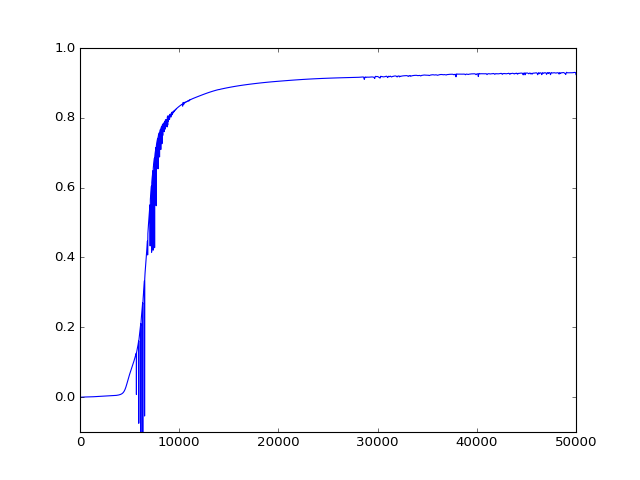

HBox(children=(IntProgress(value=0, max=50000), HTML(value=u'')))

/usr/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


NameError: name 'x' is not defined

In [9]:
fig, ax = plt.subplots(1,1) # convergence speed history

# graph
X = keras.layers.Input((3,))
h1 = keras.layers.Dense(units=12, activation="tanh", input_shape=(3,))(X)
h2 = keras.layers.Dense(units=24, activation="tanh")(h1)
h3 = keras.layers.Dense(units=16, activation="tanh")(h2)
y = keras.layers.Dense(units=1, activation=None)(h3)
G = keras.models.Model(inputs=X, outputs=y)
G.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.03, momentum=0.91, nesterov=True), metrics=[r2_score])

# session
history = G.fit(
    _X, _y,
    epochs=50000, batch_size=_X.shape[0], shuffle=True, 
    verbose=0, 
    callbacks=[
                TqdmProgBar(n_epochs=50000, field='r2_score', fig=fig, ax=ax, label='')
    ]
) # approx 5 mins

In [11]:
_yhat = G.predict(_X)
score = np.sum(np.abs(_yhat.reshape(-1) - _y.reshape(-1)))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
